In [192]:
import numpy as np
import pandas as pd
import sqlite3
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [193]:
conn = sqlite3.connect("../db/stocks.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

[('growth_stock',), ('value_stock',), ('inflation_5yr',), ('exchange',), ('CPI',), ('leverage',), ('spending',), ('GDP',), ('treasury_10yr',)]


In [215]:
cmd = '''
SELECT g.Date AS Date,
        g."Adj Close" AS GrowthStock_AdjClose,
        (g."Adj Close" - LAG(g."Adj Close", 1) OVER (ORDER BY g.Date))/ 
                LAG(g."Adj Close", 1) OVER (ORDER BY g.Date) AS GrowthStock_PercentChange,
        t."Adj Close" AS Treasure10yr_AdjClose,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY t.Date))/ 
                LAG(t."Adj Close", 1) OVER (ORDER BY t.Date) AS Treasure10yr_PercentChange,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY t.Date)) AS Treasure10yr_Diff
        
FROM growth_stock g
JOIN treasury_10yr t
ON g.Date = t.Date
'''

df = pd.read_sql_query(cmd, conn)
df.head()

,Date,GrowthStock_AdjClose,GrowthStock_PercentChange,Treasure10yr_AdjClose,Treasure10yr_PercentChange,Treasure10yr_Diff
0,2000-05-26,15.213005,NaN,6.320,NaN,NaN
1,2000-05-30,15.844181,0.041489,6.367,0.007437,0.047
2,2000-05-31,15.806020,-0.002409,6.285,-0.012879,-0.082
3,2000-06-01,16.040890,0.014860,6.195,-0.014320,-0.090
4,2000-06-02,16.569317,0.032942,6.148,-0.007587,-0.047


In [217]:
df['Date'] = pd.to_datetime(df['Date'])

In [218]:
df.isna().sum()

Date                           0
GrowthStock_AdjClose           0
GrowthStock_PercentChange      1
Treasure10yr_AdjClose          5
Treasure10yr_PercentChange    11
Treasure10yr_Diff             11
dtype: int64

In [219]:
df = df.dropna()

## EDA and Visualizations

<AxesSubplot:xlabel='Date', ylabel='GrowthStock_AdjClose'>

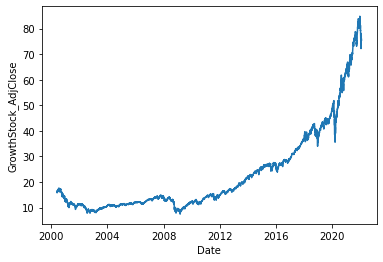

In [221]:
sns.lineplot(y='GrowthStock_AdjClose', x='Date', data = df)

<AxesSubplot:xlabel='Date', ylabel='GrowthStock_PercentChange'>

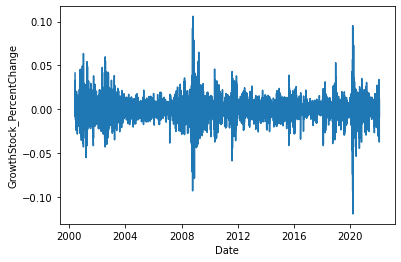

In [223]:
sns.lineplot(y='GrowthStock_PercentChange', x='Date', data = df)

<AxesSubplot:xlabel='Date', ylabel='Treasure10yr_AdjClose'>

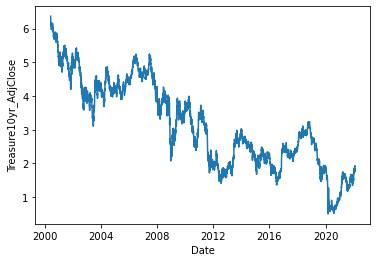

In [222]:
sns.lineplot(y='Treasure10yr_AdjClose', x='Date', data = df)

<AxesSubplot:xlabel='Date', ylabel='Treasure10yr_Diff'>

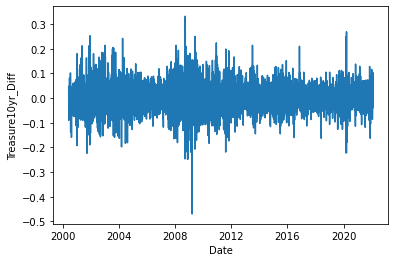

In [224]:
sns.lineplot(y='Treasure10yr_Diff', x='Date', data = df)

<AxesSubplot:xlabel='Treasure10yr_Diff', ylabel='GrowthStock_PercentChange'>

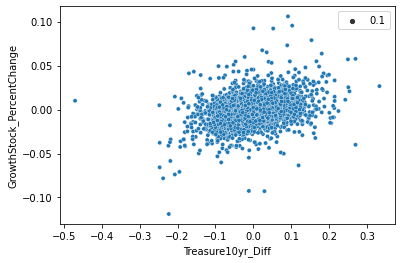

In [225]:
plt.figure(figsize = (6,4))
sns.scatterplot(x = 'Treasure10yr_Diff', 
                y = 'GrowthStock_PercentChange',
                size = 0.1,
                data = df)

## Linear Regression

In [202]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import OLSInfluence

In [208]:
X = df.Treasure10yr_PercentChange
y = df.GrowthStock_PercentChange
X = sm.add_constant(X)

model = OLS(y, X)
results = model.fit()

cooks_distance = OLSInfluence(results).cooks_distance[0]
to_remove = cooks_distance >= 4/(X.shape[0]-1)

In [209]:
X = X[~to_remove]
y = y[~to_remove]

model = OLS(y, X)
results = model.fit()

In [210]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     GrowthStock_PercentChange   R-squared:                       0.100
Model:                                   OLS   Adj. R-squared:                  0.100
Method:                        Least Squares   F-statistic:                     575.0
Date:                       Tue, 08 Feb 2022   Prob (F-statistic):          1.44e-120
Time:                               14:38:29   Log-Likelihood:                 17135.
No. Observations:                       5167   AIC:                        -3.427e+04
Df Residuals:                           5165   BIC:                        -3.425e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0006      0.000      4.698      0.000       0.000       0.001
Treasure10yr_PercentChange     0.1485      0.006     23.979      0.000       0.136       0.161
==============================================================================
Omnibus:                       78.112   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.459
Skew:                          -0.123   Prob(JB):                     7.73e-29
Kurtosis:                       3.735   Cond. No.                         50.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

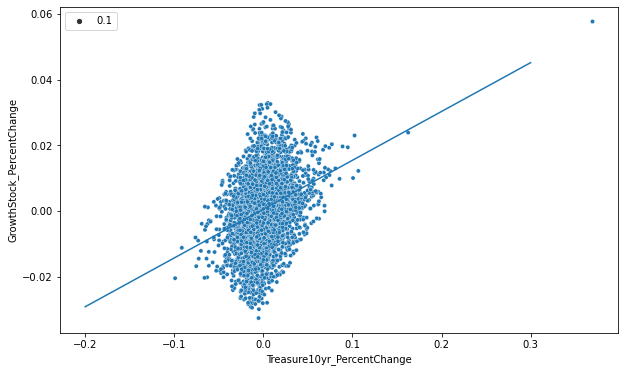

In [211]:
plt.figure(figsize = (10,6))

sns.scatterplot(x = X.iloc[:,1], 
                y = y,
                size = 0.1,
                data = df)

x0 = np.linspace(-0.2,0.3)
y0 = results.params[0] + results.params[1] * x0
plt.plot(x0, y0)

In [226]:
X = df.Treasure10yr_Diff
y = df.GrowthStock_PercentChange
X = sm.add_constant(X)

model = OLS(y, X)
results = model.fit()

cooks_distance = OLSInfluence(results).cooks_distance[0]
to_remove = cooks_distance >= 4/(X.shape[0]-1)

In [227]:
X = X[~to_remove]
y = y[~to_remove]

model = OLS(y, X)
results = model.fit()

In [228]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     GrowthStock_PercentChange   R-squared:                       0.111
Model:                                   OLS   Adj. R-squared:                  0.110
Method:                        Least Squares   F-statistic:                     635.2
Date:                       Tue, 08 Feb 2022   Prob (F-statistic):          3.42e-132
Time:                               14:48:23   Log-Likelihood:                 17104.
No. Observations:                       5106   AIC:                        -3.420e+04
Df Residuals:                           5104   BIC:                        -3.419e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0007      0.000      5.479      0.000       0.000       0.001
Treasure10yr_Diff     0.0620      0.002     25.202      0.000       0.057       0.067
==============================================================================
Omnibus:                       64.278   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.338
Skew:                          -0.136   Prob(JB):                     1.98e-21
Kurtosis:                       3.612   Cond. No.                         20.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

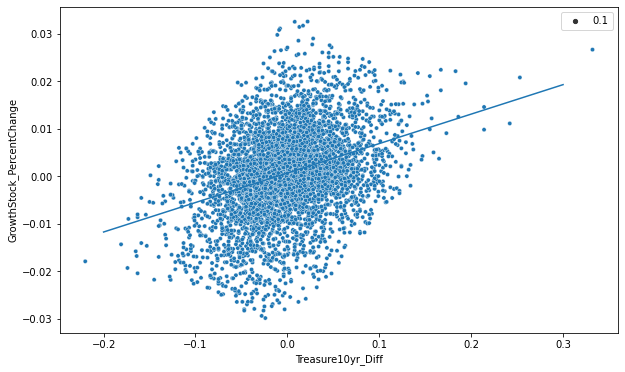

In [229]:
plt.figure(figsize = (10,6))

sns.scatterplot(x = X.iloc[:,1], 
                y = y,
                size = 0.1,
                data = df)

x0 = np.linspace(-0.2,0.3)
y0 = results.params[0] + results.params[1] * x0
plt.plot(x0, y0)

In [47]:
IVW.Date = pd.to_datetime(IVW.Date)
IVW['Diff'] = (IVW['Adj Close'] - IVW['Adj Close'].shift(1))
IVW['Percent_Change'] = (IVW['Adj Close'] - IVW['Adj Close'].shift(1))/IVW['Adj Close'].shift(1)

<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

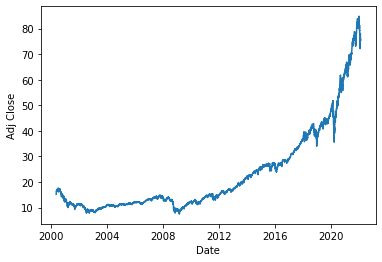

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
Adj_close = IVW['Adj Close']
Adj_close.index = df.Date.apply(lambda x: datetime.fromisoformat(x))
Adj_close.name = "Adj Close"
decomp = seasonal_decompose(Adj_close)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
# Plot decomposition
decomp.plot()
plt.tight_layout()
plt.xlabel('year')